# Evaluating Model Learning Beyond Accuracy: A Baseline Comparison Using ImageNet-Pretrained ConvNeXt with our Semisupervised Model


<b> What is being done here? <b>

1. Load mebeddings from baseline convnext and our semisupervised model
2. Calculate cosine similarity for ATG5 KO vs Unstimulated for both the baseline (ImageNet) and fine-tuned (semi-supervised) models
3. Compare the cosine similarity values between the two models
4. Quantify the difference in cosine similarity using statistical test to determine if the fine-tuned model provides significantly better similarity


Cosine similarity focuses on the direction of the vectors rather than their absolute distance, making it more robust to differences in magnitude and better suited for high-dimensional data like embeddings, where absolute distances may not always reflect true semantic similarity.


If cosine similarity is higher in the fine-tuned model compared to the ImageNet ConvNeXt, then it has learned biologically relevant relationships between cell types.
If the similarity is not significantly better, then the model may not have learned useful features, and fine-tuning needs re-evaluation.
The triangulation approach (ATG5 KO vs. Unstimulated, with Stimulated as reference) helps validate if the embeddings capture expected biological relationships.


Accuracy only measures correct classifications, but in imbalanced datasets or cases where classes are not perfectly separable, it does not reflect how well the model understands the structure of the data.
Embedding distances capture relationships between classes, which provides richer insights than just correct/incorrect predictions.

In [3]:
!pip install numpy==1.26.4 torch==2.1.0 torchvision==0.16.0 \
    transformers==4.48.1 pillow==9.2.0 anndata==0.10.3 scanpy==1.9.6 \
    matplotlib gputil leidenalg umap-learn h5py requests \
    "scikit-learn>=0.24" statsmodels==0.14.4 session-info patsy \
    safetensors==0.5.2 tokenizers==0.21.0 huggingface-hub==0.27.1 \
    llvmlite==0.44.0 numba==0.61.0 stdlib-list==0.11.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 18.2 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 670.2 MB 3.4 MB/s eta 0:00:0101   |██                              | 40.5 MB 43.5 MB/s eta 0:00:15     |██                              | 41.6 MB 43.5 MB/s eta 0:00:15     |██▊                             | 56.1 MB 43.5 MB/s eta 0:00:15     |██▉                             | 59.5 MB 43.5 MB/s eta 0:00:15     |███▏                            | 66.3 MB 43.5 MB/s eta 0:00:14     |███▍                            | 71.5 MB 43.5 MB/s eta 0:00:14     |███▋                            | 74.8 MB 30.1 MB/s eta 0:00:20     |███▋                            | 76.6 MB 30.1 MB/s eta 0:00:20     |███▊                            | 78.3 MB 30.1 MB/s eta 0:00:20     |████                            | 81.6 MB 30.1 MB/s eta 0:00:20     |████                            | 83.3 MB 30.1 MB/s eta 0:00:20     |████▌                   

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 410.6 MB 93.9 MB/s eta 0:00:011
     |████████████████████████████████| 56.5 MB 51.5 MB/s eta 0:00:01[K     |██████████████████▌             | 32.6 MB 51.5 MB/s eta 0:00:01
     |████████████████████████████████| 209.8 MB 86.4 MB/s eta 0:00:011   |████▎                           | 28.4 MB 20.1 MB/s eta 0:00:10     |███████▌                        | 49.3 MB 102.6 MB/s eta 0:00:02B 102.6 MB/s eta 0:00:02    | 75.4 MB 102.6 MB/s eta 0:00:02██████████████████████▌       | 160.3 MB 86.4 MB/s eta 0:00:01��██▋     | 174.8 MB 86.4 MB/s eta 0:00:01
     |████████████████████████████████| 196.0 MB 106.8 MB/s eta 0:00:01██████████████                | 98.0 MB 80.3 MB/s eta 0:00:02167.1 MB 80.3 MB/s eta 0:00:01
     |████████████████████████████████| 124.2 MB 103.6 MB/s eta 0:00:01█████████████▊                | 61.0 MB 65.1 MB/s eta 0:00:01
     |████████████████████████████████| 823 kB 47.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.1 MB 6

In [2]:
import os
import re
import glob
import random
import pickle
from collections import Counter
import numpy as np
import pandas as pd
import h5py
import umap
#import anndata as ad
#import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import requests
import seaborn as sns
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms, utils

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score,
    confusion_matrix
)
from sklearn.neighbors import NearestNeighbors
from transformers import AutoImageProcessor, ConvNextModel, ConvNextConfig
from sklearn.metrics.pairwise import cosine_similarity


from sparcscore.ml.datasets import HDF5SingleCellDataset
from sparcscore.ml.transforms import RandomRotation, GaussianNoise, ChannelReducer, ChannelSelector
from sparcscore.ml.utils import combine_datasets_balanced

In [3]:
#Load the semisupervised embeddings
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/"
file_name = "semisupervised_case3.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (20000, 2048)
Loaded labels shape: (20000,)
Loaded cell_ids shape: (20000,)


In [4]:
#Second semisupervised run
#Load the semisupervised embeddings
save_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/semisupervised_convnext/"
file_name = "semisupervised_case3_v2.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (20000, 2048)
Loaded labels shape: (20000,)
Loaded cell_ids shape: (20000,)


In [5]:
# Load the baseline (non finetuned!) Convnext from Imagenet as we get it from Huggingface

pool_path = './convnext_output_files/pool.npy'
labels_path = './convnext_output_files/labels.npy'
class_ids_path = './convnext_output_files/class_ids.npy'

# Load the data
output_avg = np.load(pool_path)  
labels = np.load(labels_path)   
class_ids = np.load(class_ids_path)  

In [6]:
# Compute cosine similarity matrix for the semi-supervised model embeddings
cosine_sim_semisupervised = cosine_similarity(embeddings)

# Compute cosine similarity matrix for the ImageNet-pretrained ConvNeXt embeddings
cosine_sim_baseline = cosine_similarity(output_avg)

# Compare specific class distances
def get_class_similarity(similarity_matrix, labels, class_a, class_b):
    indices_a = np.where(labels == class_a)[0]
    indices_b = np.where(labels == class_b)[0]
    
    # Compute mean similarity between the two classes
    similarity_values = similarity_matrix[np.ix_(indices_a, indices_b)]
    return np.mean(similarity_values)


In [16]:
# Compute pairwise similarities (absolute)
atg5_unstim_baseline = get_class_similarity(cosine_sim_baseline, labels, class_a=2, class_b=1)
atg5_unstim_semisupervised = get_class_similarity(cosine_sim_semisupervised, labels_list, class_a=2, class_b=1)

print(f"Baseline (ImageNet ConvNeXt) ATG5 KO vs Unstimulated: {atg5_unstim_baseline:.4f}")
print(f"Fine-tuned (Semi-supervised) ATG5 KO vs Unstimulated: {atg5_unstim_semisupervised:.4f}")

Baseline (ImageNet ConvNeXt) ATG5 KO vs Unstimulated: 0.1649
Fine-tuned (Semi-supervised) ATG5 KO vs Unstimulated: 0.3811


In [8]:
# Compute pairwise similarities (relative first semisupervised run!)
atg5_unstim_baseline = get_class_similarity(cosine_sim_baseline, labels, class_a=2, class_b=1)
atg5_wt_baseline = get_class_similarity(cosine_sim_baseline, labels, class_a=2, class_b=0)

atg5_unstim_semisupervised = get_class_similarity(cosine_sim_semisupervised, labels_list, class_a=2, class_b=1)
atg5_wt_semisupervised = get_class_similarity(cosine_sim_semisupervised, labels_list, class_a=2, class_b=0)

# Compute relative similarity by normalizing
relative_baseline = atg5_unstim_baseline / atg5_wt_baseline
relative_semisupervised = atg5_unstim_semisupervised / atg5_wt_semisupervised

# Print results
print(f"Baseline (ImageNet ConvNeXt) Relative ATG5 KO vs Unstimulated: {relative_baseline:.4f}")
print(f"Fine-tuned (Semi-supervised) Relative ATG5 KO vs Unstimulated: {relative_semisupervised:.4f}")

Baseline (ImageNet ConvNeXt) Relative ATG5 KO vs Unstimulated: -2.5478
Fine-tuned (Semi-supervised) Relative ATG5 KO vs Unstimulated: 5.9047


In [5]:
# Compute pairwise similarities (relative! second semisupervised run)
atg5_unstim_baseline = get_class_similarity(cosine_sim_baseline, labels, class_a=2, class_b=1)
atg5_wt_baseline = get_class_similarity(cosine_sim_baseline, labels, class_a=2, class_b=0)

atg5_unstim_semisupervised = get_class_similarity(cosine_sim_semisupervised, labels_list, class_a=2, class_b=1)
atg5_wt_semisupervised = get_class_similarity(cosine_sim_semisupervised, labels_list, class_a=2, class_b=0)

# Compute relative similarity by normalizing
relative_baseline = atg5_unstim_baseline / atg5_wt_baseline
relative_semisupervised = atg5_unstim_semisupervised / atg5_wt_semisupervised

# Print results
print(f"Baseline (ImageNet ConvNeXt) Relative ATG5 KO vs Unstimulated: {relative_baseline:.4f}")
print(f"Fine-tuned (Semi-supervised) Relative ATG5 KO vs Unstimulated: {relative_semisupervised:.4f}")


Baseline (ImageNet ConvNeXt) Relative ATG5 KO vs Unstimulated: -2.5478
Fine-tuned (Semi-supervised) Relative ATG5 KO vs Unstimulated: 2.4761


class similarities by normalizing the ATG5 KO vs Unstimulated (2 vs 1) distance using Unstimulated vs WT (2 vs 0) as a reference

In [7]:
# Shift cosine similarity values to be positive
cosine_sim_baseline_positive = cosine_sim_baseline + 1
cosine_sim_semisupervised_positive = cosine_sim_semisupervised + 1

# Now recompute the class similarities using the shifted cosine similarity matrices
atg5_unstim_baseline = get_class_similarity(cosine_sim_baseline_positive, labels, class_a=2, class_b=1)
atg5_wt_baseline = get_class_similarity(cosine_sim_baseline_positive, labels, class_a=2, class_b=0)

atg5_unstim_semisupervised = get_class_similarity(cosine_sim_semisupervised_positive, labels_list, class_a=2, class_b=1)
atg5_wt_semisupervised = get_class_similarity(cosine_sim_semisupervised_positive, labels_list, class_a=2, class_b=0)

# Compute relative similarity by normalizing
relative_baseline = atg5_unstim_baseline / atg5_wt_baseline
relative_semisupervised = atg5_unstim_semisupervised / atg5_wt_semisupervised

# Print the updated results
print(f"Baseline (ImageNet ConvNeXt) Relative ATG5 KO vs Unstimulated: {relative_baseline:.4f}")
print(f"Fine-tuned (Semi-supervised) Relative ATG5 KO vs Unstimulated: {relative_semisupervised:.4f}")

Baseline (ImageNet ConvNeXt) Relative ATG5 KO vs Unstimulated: 1.2455
Fine-tuned (Semi-supervised) Relative ATG5 KO vs Unstimulated: 1.1866


In [9]:
from scipy.stats import wilcoxon

# Collect similarity values into arrays
baseline_similarities = np.array([atg5_unstim_baseline, atg5_wt_baseline])
semisupervised_similarities = np.array([atg5_unstim_semisupervised, atg5_wt_semisupervised])

# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(baseline_similarities, semisupervised_similarities)
print(f"Wilcoxon test: test-statistic = {stat:.4f}, p-value = {p_value:.4f}")

Wilcoxon test: test-statistic = 0.0000, p-value = 0.5000


In [11]:
from scipy.stats import ttest_rel

# Perform paired t-test
t_stat, p_value = ttest_rel(baseline_similarities, semisupervised_similarities)
print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

Paired t-test: t-statistic = -25.1029, p-value = 0.0253


Paired t-test: t-statistic = -2.9173, p-value = 0.1002


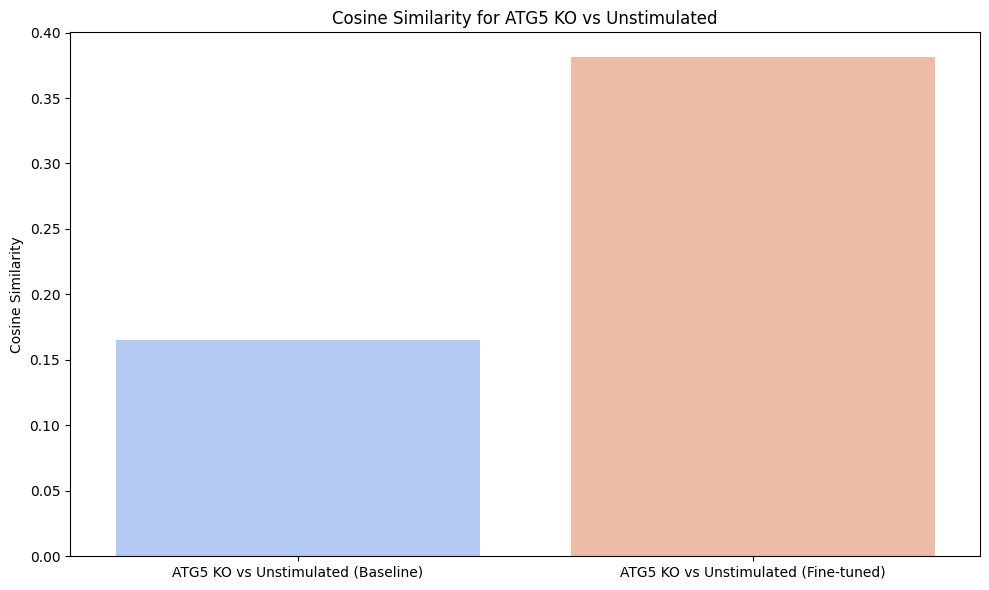

In [21]:
# Collect all cosine similarity values for comparison
baseline_similarities = [get_class_similarity(cosine_sim_baseline, labels, class_a=2, class_b=i) for i in range(3)]  # Compare with different classes
semisupervised_similarities = [get_class_similarity(cosine_sim_semisupervised, labels_list, class_a=2, class_b=i) for i in range(3)]

# Perform statistical comparison (Paired t-test or Wilcoxon test)
t_stat, p_value = stats.ttest_rel(baseline_similarities, semisupervised_similarities)
print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# Plot the cosine similarity values for both models
plt.figure(figsize=(10, 6))
sns.barplot(x=['ATG5 KO vs Unstimulated (Baseline)', 'ATG5 KO vs Unstimulated (Fine-tuned)'],
            y=[atg5_unstim_baseline, atg5_unstim_semisupervised],
            palette='coolwarm')
plt.title('Cosine Similarity for ATG5 KO vs Unstimulated')
plt.ylabel('Cosine Similarity')
plt.tight_layout()
plt.show()

In [23]:
import numpy as np

def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x) ** 2 + np.std(y) ** 2) / 2)

d = cohen_d(cosine_sim_baseline.flatten(), cosine_sim_semisupervised.flatten())
print(f"Cohen's d: {d}")

Cohen's d: -1.7441036556237801


In [24]:
cosine_sim_baseline_flattened = cosine_sim_baseline.flatten()
cosine_sim_semisupervised_flattened = cosine_sim_semisupervised.flatten()

print(len(cosine_sim_baseline_flattened), len(cosine_sim_semisupervised_flattened))

1764000000 400000000


In [25]:
min_length = min(len(cosine_sim_baseline_flattened), len(cosine_sim_semisupervised_flattened))

cosine_sim_baseline_flattened = cosine_sim_baseline_flattened[:min_length]
cosine_sim_semisupervised_flattened = cosine_sim_semisupervised_flattened[:min_length]

stat, p_value = wilcoxon(cosine_sim_baseline_flattened, cosine_sim_semisupervised_flattened)
print(f"Wilcoxon test p-value: {p_value}")

Wilcoxon test p-value: 0.0


In [17]:
from sklearn.metrics import silhouette_score

# Use the labels from your model or ground truth (use the same labels as you used for cosine similarity)
sil_score_semisupervised = silhouette_score(embeddings, labels_list, metric="cosine")
sil_score_baseline = silhouette_score(output_avg, labels, metric="cosine")

print(f"Silhouette Score (Fine-tuned Semi-supervised): {sil_score_semisupervised:.4f}")
print(f"Silhouette Score (Baseline ImageNet ConvNeXt): {sil_score_baseline:.4f}")

Silhouette Score (Fine-tuned Semi-supervised): 0.1901
Silhouette Score (Baseline ImageNet ConvNeXt): 0.0423
